# Energy Consumption Analysis for 15-minute Interval Data

This notebook provides a comprehensive analysis of energy consumption data that is recorded at 15-minute intervals. Our goal is to derive meaningful insights from the data and answer specific questions related to energy usage patterns.

**Key Objectives:**
1. Determine annual energy consumption.
2. Calculate the annual cost based on a given electricity price per kWh.
3. Analyze daily consumption patterns and monthly breakdowns.
4. Study consumption differences across days of the week.
5. Examine intra-day consumption distribution.
6. Identify days with peak consumption at 15-minute intervals.
7. Highlight the top 5 days with the highest instantaneous power usage.
8. Create a histogram to visualize quarterly consumption values relative to the total.
9. Compare solar panel production against consumption.
10. Optimize and understand car charger energy consumption.

## Beginning the Analysis

In this analysis, we examine the energy consumption data from multiple meters. The dataset provides consumption values in 15-minute intervals. Our goal is to preprocess this data and derive valuable insights from various perspectives, such as annual, daily, and intra-day consumption patterns.

### Setting up the Environment

To ensure our analysis runs smoothly, we've taken the following steps:

**Created a Virtual Environment:** This helps to keep our project dependencies separate from other Python projects. By using a virtual environment, we ensure that our project runs consistently across different setups.

**Installed Necessary Libraries:** Our project leverages several Python libraries that aid in data manipulation, visualization, and analysis. These libraries have been automatically installed in the virtual environment to guarantee the reproducibility of our analysis.

**Imported Libraries:** The required libraries for this notebook have been imported upfront to streamline the analysis process. These libraries provide a variety of functions and tools essential for our tasks.

**Importing Custom Utility Functions:** To modularize our analysis and promote code reusability, we've defined custom functions in separate Python files. In this section, we'll import these utility functions to be used throughout our notebook.

**Loaded Configuration:** Constants and configurations, such as file paths and threshold values, are sourced from a .env file. This approach promotes better code management and security


In [4]:
# ---------------
# SETTING UP THE ENVIRONMENT
# ---------------
# This cell is meant to be run once to set up the virtual environment and install necessary packages.

# Specifying the name for your environment. (.venv-zenalysis is the default name)
ENV_NAME = ".venv-zenalysis"

# Importing the necessary packages
import sys

# Adjusting the Python path to include the root directory
sys.path.append('../')

# Importing functions for setting up our environment
from src import environment_setup as ce

# Create the virtual environment
ce.create_environment(ENV_NAME)

# Install required packages into the virtual environment
ce.install_packages(ENV_NAME)

# Setting default values for .env file, DON'T FORGET TO CHANGE THESE VALUES
SOURCE_FILE_PATH = "YOUR_FILE_PATH_HERE"
PRICE_PER_KWH = 0.000
# The threshold for outliers is the number of standard deviations from the mean
THRESHOLD_FOR_OUTLIERS = 1.5

# TODO: Add currency
# TODO: Add RoI, price for solar panels, etc.

# Create .env file for storing constants and configurations
ce.create_dotenv_file(SOURCE_FILE_PATH, PRICE_PER_KWH, THRESHOLD_FOR_OUTLIERS)

### Activating the Virtual Environment

Depending on your operating system, the command to activate the virtual environment differs:

#### Windows

To activate the virtual environment on Windows, navigate to the directory containing your virtual environment and run:

```bash
.venv-zenalysis\Scripts\activate
```

#### macOS and Linux

For macOS and Linux users, navigate to the directory containing your virtual environment and run:

```bash
source .venv-zenalysis/bin/activate
```


In [5]:
# ---------------
# IMPORTING LIBRARIES
# ---------------
# Importing all the necessary libraries required for our analysis.

# Standard Libraries
import os
import calendar

# Third-party Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from dotenv import load_dotenv

In [6]:
# ---------------
# LOADING CONSTANTS FROM .ENV
# ---------------
# Loading constants and configurations stored in the .env file.

# Load values from .env
load_dotenv()

# Define constants
SOURCE_FILE_PATH = os.getenv('SOURCE_FILE_PATH', 'FILE_PATH_HERE')  # default path if not found
PRICE_PER_KWH = float(os.getenv('PRICE_PER_KWH', '183.5'))  # default value if not found
THRESHOLD_FOR_OUTLIERS = float(os.getenv('THRESHOLD_FOR_OUTLIERS', '1.5'))  # default value if not found

### Data Preprocessing

The raw dataset contains date-time information in a non-standard format. In this step:

1. The dataset is loaded into a DataFrame.
2. A new DataFrame is created to hold the processed data.
3. The combined date-time column is split into separate date, start time, and end time values.
4. These separated values are then used to create two new columns: TimePeriodStart and TimePeriodEnd, which represent the start and end of each 15-minute interval in a standard datetime format.
5. The original combined date-time column is dropped.

In [7]:
print("SOURCE_FILE_PATH: ", SOURCE_FILE_PATH)

SOURCE_FILE_PATH:  D:\Repos\zengrid-analysis\data\Ivanics Autopark_hajo_KM.xlsx


In [8]:
# Importing utility functions for data processing and analysis
from utils import data_utils as du

# Task1: Load the data using the defined function
data = du.read_data_file(SOURCE_FILE_PATH, skiprows=[1])

# Task 2: Preprocessing 
processed_data = data.copy()

# Extracting date, start time, and end time from 'Időszeletek'
date = processed_data['Időszeletek'].str.split(' ').str[0]
start_time = processed_data['Időszeletek'].str.split(' - ').str[0].str.split(' ').str[1]
end_time = processed_data['Időszeletek'].str.split(' - ').str[1]

processed_data['TimePeriodStart'] = date + ' ' + start_time
processed_data['TimePeriodEnd'] = date + ' ' + end_time

# Adjust for '24:00' in TimePeriodEnd
mask_24 = processed_data['TimePeriodEnd'].str.endswith('24:00')
processed_data.loc[mask_24, 'TimePeriodEnd'] = (pd.to_datetime(processed_data.loc[mask_24, 'TimePeriodEnd'].str.split(' ').str[0]) + pd.Timedelta(days=1)).dt.strftime('%Y.%m.%d') + ' 00:00'

processed_data['TimePeriodStart'] = pd.to_datetime(processed_data['TimePeriodStart'], format='%Y.%m.%d %H:%M')
processed_data['TimePeriodEnd'] = pd.to_datetime(processed_data['TimePeriodEnd'], format='%Y.%m.%d %H:%M')

processed_data.drop('Időszeletek', axis=1, inplace=True)

# Replace NaN values with 0
processed_data.fillna(0, inplace=True)

# Extracting DayOfWeek, Month, Hour, and Minute from 'TimePeriodStart'
processed_data['DayOfWeek'] = processed_data['TimePeriodStart'].dt.dayofweek
processed_data['Month'] = processed_data['TimePeriodStart'].dt.month
processed_data['Hour'] = processed_data['TimePeriodStart'].dt.hour
processed_data['Minute'] = processed_data['TimePeriodStart'].dt.minute

# Task 3: Distinguish between different meters
consumption_meter_columns = [col for col in processed_data.columns if 'PV' not in col and 'ECC' not in col and 'TimePeriod' not in col and col != 'DayOfWeek' and col != 'Month' and col != 'Hour' and col != 'Minute']
solar_panel_columns = [col for col in processed_data.columns if 'PV' in col]
electric_car_charger_columns = [col for col in processed_data.columns if 'ECC' in col]

# Display the processed data and its types
processed_data.head(), processed_data.dtypes

(   HU000210F11-S00000000000005002818  HU000210F11-S00000000000005002818/PV  \
 0                              3.488                                   0.0   
 1                              3.488                                   0.0   
 2                              3.450                                   0.0   
 3                              3.538                                   0.0   
 4                              3.763                                   0.0   
 
    HU000210F11-S00000000000005003426  HU000210F11-S00000000000005003426/PV  \
 0                               2.40                                   0.0   
 1                               2.40                                   0.0   
 2                               2.26                                   0.0   
 3                               2.56                                   0.0   
 4                               2.44                                   0.0   
 
    HU000210F11-S00000000000016231220/ECC  \
 0 

### Task 1: Calculate annual consumption
This task involves understanding the annual consumption of each meter and calculating associated costs:

1. The annual consumption for each meter is computed by summing up its respective values.
2. The annual cost for each meter is derived using a given price per kWh.
3. Average daily consumption is computed for each 15-minute interval throughout the entire year.
4. Average monthly consumption is calculated for each 15-minute interval, grouped by month.
5. A visualization is created to showcase the average consumption per hour throughout the year.

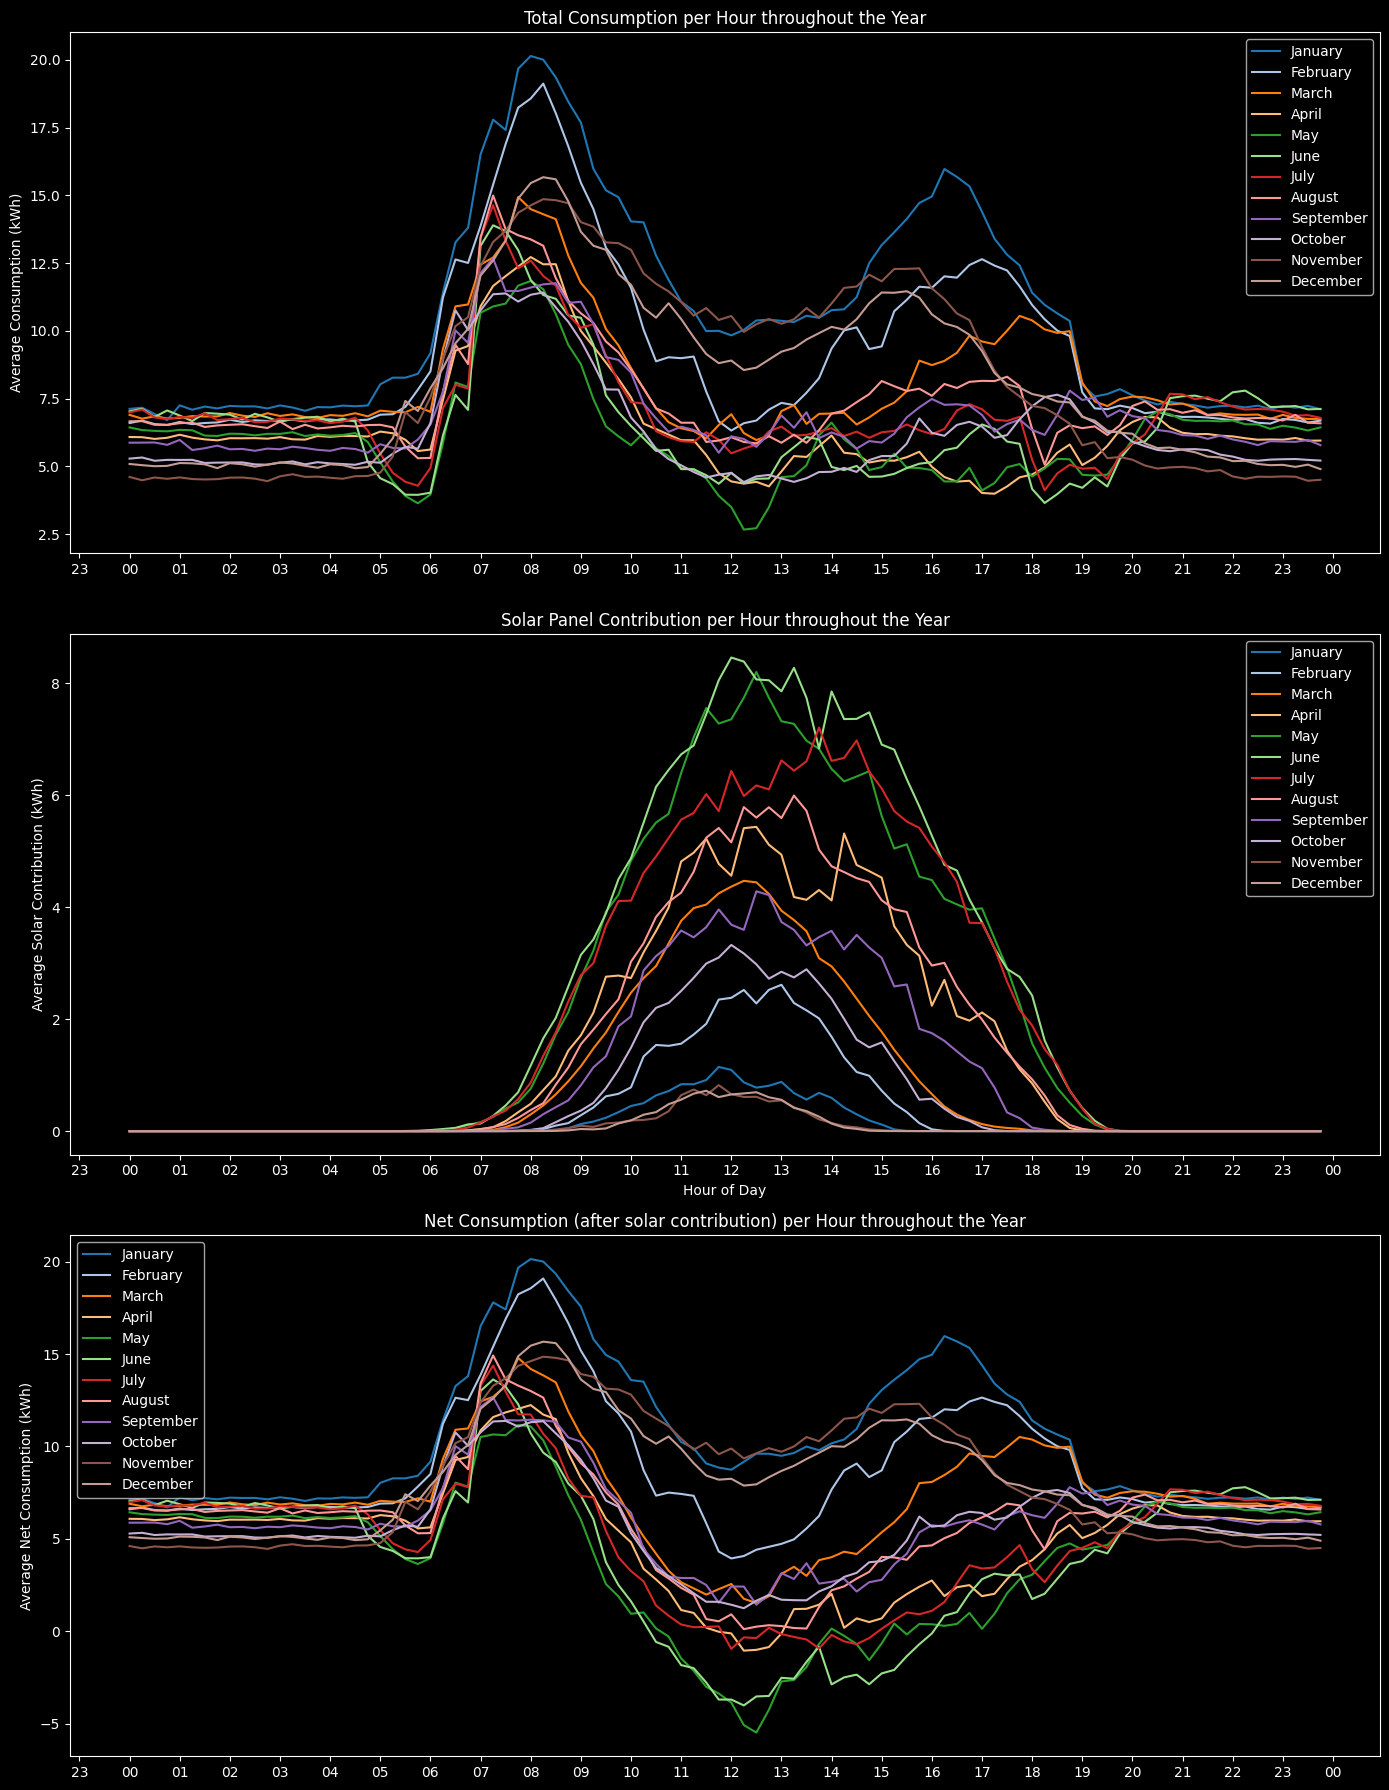

In [9]:
# Step 1: Calculate annual consumption for each type of meter
annual_consumption = processed_data[consumption_meter_columns].sum()

# Step 2: Calculate annual costs
annual_costs = annual_consumption * PRICE_PER_KWH

# Step 3: Average daily consumption for each 15-minute interval is already done in preprocessing
# We have 'Hour' and 'Minute' columns created in the preprocessing step.
avg_daily_consumption = processed_data.groupby(['Hour', 'Minute']).mean().reset_index()

# Step 4: Average daily consumption for each 15-minute interval grouped by month
# 'Month' column was also created during preprocessing.
avg_monthly_consumption = processed_data.groupby(['Month', 'Hour', 'Minute']).mean().reset_index()

# Generating time column for plotting
avg_monthly_consumption['Time'] = avg_monthly_consumption['Hour'].astype(str).str.zfill(2) + ':' + avg_monthly_consumption['Minute'].astype(str).str.zfill(2)
avg_monthly_consumption['PlotTime'] = pd.to_datetime('2000-01-01 ' + avg_monthly_consumption['Time'])

# Calculate total consumption across all consumption meters and electric car chargers
avg_monthly_consumption['TotalConsumption'] = avg_monthly_consumption[consumption_meter_columns + electric_car_charger_columns].sum(axis=1)

# Calculate net consumption (total consumption minus solar panel production)
avg_monthly_consumption['NetConsumption'] = avg_monthly_consumption['TotalConsumption'] - avg_monthly_consumption[solar_panel_columns].sum(axis=1)

# Calculate the difference contributed by the solar panels
avg_monthly_consumption['SolarContribution'] = avg_monthly_consumption['TotalConsumption'] - avg_monthly_consumption['NetConsumption']

# Define the color palette
palette = sns.color_palette("tab20", 12)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 18))

# Plotting Total Consumption
for month, color in zip(avg_monthly_consumption['Month'].unique(), palette):
    monthly_data = avg_monthly_consumption[avg_monthly_consumption['Month'] == month]
    ax1.plot(monthly_data['PlotTime'], monthly_data['TotalConsumption'], label=calendar.month_name[month], color=color)
ax1.set_title("Total Consumption per Hour throughout the Year")
ax1.set_ylabel("Average Consumption (kWh)")
ax1.legend()

# Plotting Solar Panel Contribution
for month, color in zip(avg_monthly_consumption['Month'].unique(), palette):
    monthly_data = avg_monthly_consumption[avg_monthly_consumption['Month'] == month]
    ax2.plot(monthly_data['PlotTime'], monthly_data['SolarContribution'], label=calendar.month_name[month], color=color)
ax2.set_title("Solar Panel Contribution per Hour throughout the Year")
ax2.set_xlabel("Hour of Day")
ax2.set_ylabel("Average Solar Contribution (kWh)")
ax2.legend()

# Plotting Net Consumption
for month, color in zip(avg_monthly_consumption['Month'].unique(), palette):
    monthly_data = avg_monthly_consumption[avg_monthly_consumption['Month'] == month]
    ax3.plot(monthly_data['PlotTime'], monthly_data['NetConsumption'], label=calendar.month_name[month], color=color)
ax3.set_title("Net Consumption (after solar contribution) per Hour throughout the Year")
ax3.set_ylabel("Average Net Consumption (kWh)")
ax3.legend()

# Formatting axes
for ax in [ax1, ax2, ax3]:
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))

plt.tight_layout()
plt.show()

### Task 2: Daily Consumption Patterns and Monthly Breakdowns

This task aims to identify patterns in consumption across different days of the week:

1. Average consumption values for each day of the week are computed.
2. A bar chart is created to showcase the average consumption for each day, from Monday to Sunday.

In [ ]:
# Include car chargers in the consumption columns
electric_car_charger_columns = [col for col in processed_data.columns if 'ECC' in col]
all_consumption_columns = consumption_meter_columns + electric_car_charger_columns

# Calculate average consumption for the days of the week for each month
processed_data['DayOfWeek'] = processed_data['TimePeriodStart'].dt.dayofweek
avg_weekly_monthly_consumption = processed_data.groupby(['Month', 'DayOfWeek']).mean()[all_consumption_columns].reset_index()

# Convert numerical day representation to actual day names
avg_weekly_monthly_consumption['DayOfWeekName'] = avg_weekly_monthly_consumption['DayOfWeek'].apply(lambda x: calendar.day_name[x])

# Visualization with Enhancements
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15), sharex=True, sharey=True)
days_order = list(calendar.day_name)

for month in range(1, 13):
    ax = axes[(month-1) // 4][(month-1) % 4]
    
    monthly_data = avg_weekly_monthly_consumption[avg_weekly_monthly_consumption['Month'] == month]
    
    bars = []
    for column in all_consumption_columns:
        bars.append(ax.bar(monthly_data['DayOfWeekName'], monthly_data[column], label=column, alpha=0.7))
    
    # Set bar labels
    for bar_set in bars:
        for bar in bar_set:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, yval + 0.1, round(yval,2), ha='center', va='bottom', fontsize=9)
    
    ax.set_title(calendar.month_name[month])
    ax.set_xticks(list(range(7)))  # Set x-ticks for every day
    ax.set_xticklabels(days_order, rotation=45, ha='right')  
    ax.grid(axis='y')
    ax.set_ylabel('Avg Consumption (kWh)')

# Add a legend to the figure
fig.legend(all_consumption_columns, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=len(all_consumption_columns))

plt.tight_layout()
plt.show()

In [ ]:
# Extract day of the week
processed_data['DayOfWeek'] = processed_data['TimePeriodStart'].dt.dayofweek

# Calculate average consumption for the days of the week
avg_weekly_consumption = processed_data.groupby('DayOfWeek').mean().reset_index()

# Convert numerical day representation to actual day names
avg_weekly_consumption['DayOfWeek'] = avg_weekly_consumption['DayOfWeek'].apply(lambda x: calendar.day_name[x])

# Visualization of average consumption across the days of the week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
avg_weekday_consumption = avg_weekly_consumption.set_index('DayOfWeek').reindex(days_order).reset_index()

# Set up plotting parameters
width = 0.2
x = np.arange(len(days_order))

plt.figure(figsize=(14, 8))
bar_colors = sns.color_palette("tab10", len(all_consumption_columns))
for idx, (column, color) in enumerate(zip(all_consumption_columns, bar_colors), 1):
    plt.bar(x - width * len(all_consumption_columns) / 2 + idx * width, avg_weekday_consumption[column], width, label=column, color=color)

# Set labels, title, and custom x-axis tick labels
plt.ylabel('Average Consumption (kWh)')
plt.xlabel('Day of the Week')
plt.title('Average Consumption per Day of the Week (2022)')
plt.xticks(x, days_order)
plt.legend(loc='upper left')

plt.tight_layout()
plt.grid(axis='y')
plt.show()

### Task 3: Examining Intra-day Consumption Distribution

This task delves into the consumption patterns within a day:

1. The data is grouped by hours and minutes to determine the average consumption for each 15-minute interval throughout the day.
2. A line plot is created to show the intra-day distribution of average consumption.

In [ ]:
# Step 1: Calculate average consumption for each 15-minute interval of the day

# As we have already extracted 'Hour' and 'Minute' in the preprocessing step, we can directly compute the average.
avg_intra_day = processed_data.groupby(['Hour', 'Minute']).mean()[all_consumption_columns].reset_index()

# Convert 'Hour' and 'Minute' to a time format for better visualization
avg_intra_day['Time'] = avg_intra_day['Hour'].astype(str).str.zfill(2) + ':' + avg_intra_day['Minute'].astype(str).str.zfill(2)

# Step 2: Visualization of intra-day consumption patterns

plt.figure(figsize=(16, 8))

# Plot data for each consumption column
for column in all_consumption_columns:
    plt.plot(avg_intra_day['Time'], avg_intra_day[column], label=column, marker='o', markersize=3)

# Set labels, title, and format the x-axis
plt.xlabel('Time of Day')
plt.ylabel('Average Consumption (kWh)')
plt.title('Intra-day Distribution of Average Consumption (2022)')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y')

plt.tight_layout()
plt.show()

### Task 4: Identifying Days with Peak Consumption at 15-minute Intervals

This task focuses on identifying periods of peak consumption:

1. The data is analyzed to find the 15-minute intervals with the highest total power consumption.
2. The top 5 unique days with the highest instantaneous power are identified.
3. A line plot is created to show the intra-day power distribution for these top 5 unique days.

In [ ]:
# Step 1: Convert to kWh
# Multiplying by 4 to convert kW readings of 15-minute intervals to kWh
avg_intra_day[all_consumption_columns] *= 4

# Step 2: Calculate total consumption for each time interval
avg_intra_day['Total'] = avg_intra_day[all_consumption_columns].sum(axis=1)

# Step 3: Identify peak consumption time
peak_time = avg_intra_day.iloc[avg_intra_day['Total'].idxmax()]['Time']
peak_value = avg_intra_day['Total'].max()

# Step 4: Visualization

plt.figure(figsize=(16, 8))

# Plot data for each consumption column
for column in all_consumption_columns:
    plt.plot(avg_intra_day['Time'], avg_intra_day[column], label=column, marker='o', markersize=3)

# Highlight the peak consumption period
plt.axvline(peak_time, color='red', linestyle='--', label=f'Peak Consumption at {peak_time}')
plt.axhline(peak_value, color='green', linestyle='--', label=f'Peak Consumption: {peak_value:.2f} kWh')

# Set labels, title, and format the x-axis
plt.xlabel('Time of Day')
plt.ylabel('Average Consumption (kWh)')
plt.title('Intra-day Distribution of Average Consumption with Peak Highlighted (2022)')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y')

plt.tight_layout()
plt.show()

### Task 5: Identify the top 5 days with the highest instantaneous power.

The focus of this task is to pinpoint periods of peak consumption:

1. **Highlighting Peak Intervals**:
    - The dataset is first scoured to identify the 15-minute intervals with the top 5 highest total power consumptions. It's worth noting that multiple peak values might occur on the same day. The visual representation of this data will underscore these peak values, allowing us to identify the most power-intensive moments throughout the year.
2. **Analysis of Unique Peak Days**:
    - To get a broader view, we delve deeper to identify the top 5 unique days that experienced the highest instantaneous power. This approach ensures we're not just looking at isolated peak intervals but rather entire days of significant power usage.
    - A line plot is then crafted to vividly display the intra-day power distribution for each of these standout days, painting a clear picture of consumption dynamics on these particularly demanding days.

By the culmination of this task, we'll have a nuanced understanding of both instantaneous power spikes and broader days of high consumption, offering a multifaceted view of peak usage periods.

In [ ]:
# Step 1: Convert consumption to power (kW)
# Since the data is for 15-minute intervals, we multiply by 4 to get kW
processed_data[all_consumption_columns] *= 4

# Calculate total power for each interval
processed_data['TotalPower'] = processed_data[all_consumption_columns].sum(axis=1)

# Step 2: Identify top 5 intervals with the highest power
top_5_intervals = processed_data.nlargest(5, 'TotalPower')

# Step 3: Extract unique dates from top intervals
unique_top_dates = top_5_intervals['TimePeriodStart'].dt.date.unique()

print("Top 5 Dates with the Highest Instantaneous Power:")
for date in unique_top_dates:
    print(date)

# Step 4: Visualization

plt.figure(figsize=(16, 10))

# Plotting intra-day distribution for each unique top date
for date in unique_top_dates:
    subset = processed_data[processed_data['TimePeriodStart'].dt.date == date]
    time = subset['TimePeriodStart'].dt.strftime('%H:%M')
    plt.plot(time, subset['TotalPower'], label=str(date), marker='o', markersize=4)

# Adjusting the plot
plt.xlabel('Time of Day')
plt.ylabel('Power (kW)')
plt.title('Intra-day Power Distribution for Days with Highest Instantaneous Power')
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()

plt.show()

In [ ]:
# Calculate daily total power
daily_total_power = processed_data.groupby(processed_data['TimePeriodStart'].dt.date)['TotalPower'].sum()

# Get top 5 unique dates with the highest total power
top_5_dates = daily_total_power.nlargest(5).index

print("Top 5 Dates with the Highest Instantaneous Power:")
for date in top_5_dates:
    print(date)

# Visualization
plt.figure(figsize=(16, 10))

# Plotting intra-day distribution for each unique top date
for date in top_5_dates:
    subset = processed_data[processed_data['TimePeriodStart'].dt.date == date]
    time = subset['TimePeriodStart'].dt.strftime('%H:%M')
    plt.plot(time, subset['TotalPower'], label=str(date), marker='o', markersize=4)

# Adjusting the plot
plt.xlabel('Time of Day')
plt.ylabel('Power (kW)')
plt.title('Intra-day Power Distribution for Days with Highest Instantaneous Power')
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()

plt.show()

### Task 6: Visualizing Quarterly Consumption

This task aims to understand the distribution of daily energy consumption for each meter:

1. Histograms are created for each meter to show the distribution of daily energy consumption values.
2. These histograms provide insights into the frequency of different daily consumption values for each meter, highlighting common consumption patterns and any anomalies.

In [ ]:
# Compute the daily energy consumption for each meter
processed_data['Date'] = processed_data['TimePeriodStart'].dt.date
daily_consumption = processed_data.groupby('Date')[all_consumption_columns].sum()

# Setting up the plotting environment
sns.set_style("whitegrid")
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))

# Plotting histograms for each meter
for idx, column in enumerate(all_consumption_columns):
    sns.histplot(daily_consumption[column], ax=axes[idx], bins=30, kde=True, color='skyblue', edgecolor='black')
    
    # Setting titles and labels for each subplot
    axes[idx].set_title(f'Distribution of Daily Energy Consumption for {column}')
    axes[idx].set_xlabel('Daily Energy Consumption (kWh)')
    axes[idx].set_ylabel('Frequency')

# Adjusting the layout to prevent overlap
plt.tight_layout()

# Displaying the plots
plt.show()


### Task 8: Anomaly detection
Here's a basic approach to detect anomalies using the interquartile range (IQR):

IQR Method:
- Calculate the first (Q1) and third quartiles (Q3) for the data.
- Compute the IQR: IQR=Q3−Q1IQR=Q3−Q1.
- Define a threshold for outliers, typically 1.5 times the IQR below Q1 and above Q3.
- Data points outside of this range are considered anomalies.

Let's implement this for daily energy consumption:

In [ ]:
# For each meter, calculate Q1, Q3, IQR, and the bounds for outliers
thresholds = {}

for column in all_consumption_columns:
    Q1 = daily_consumption[column].quantile(0.25)
    Q3 = daily_consumption[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - THRESHOLD_FOR_OUTLIERS * IQR
    upper_bound = Q3 + THRESHOLD_FOR_OUTLIERS * IQR
    
    thresholds[column] = {"Lower Bound": lower_bound, "Upper Bound": upper_bound}

# Display thresholds for each meter
for meter, bounds in thresholds.items():
    print(f"Thresholds for {meter}:")
    print(f"  - Lower Bound: {bounds['Lower Bound']:.2f}")
    print(f"  - Upper Bound: {bounds['Upper Bound']:.2f}")
    print("\n")


In [ ]:
# For each meter, calculate Q1, Q3, IQR, and the bounds for outliers
anomaly_dates = {}

for column in all_consumption_columns:
    Q1 = daily_consumption[column].quantile(0.25)
    Q3 = daily_consumption[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - THRESHOLD_FOR_OUTLIERS * IQR
    upper_bound = Q3 + THRESHOLD_FOR_OUTLIERS * IQR
    
    # Extract dates of the anomalies
    anomaly_dates[column] = daily_consumption[(daily_consumption[column] < lower_bound) | (daily_consumption[column] > upper_bound)].index

# Display dates of anomalies for each meter
for meter, dates in anomaly_dates.items():
    print(f"Anomaly Dates for {meter}:")
    for date in dates:
        print(f"  - {date.strftime('%Y-%m-%d')}")
    print("\n")


In [ ]:
# For each meter, calculate Q1, Q3, IQR, and the bounds for outliers
anomalies = {}

for column in all_consumption_columns:
    Q1 = daily_consumption[column].quantile(0.25)
    Q3 = daily_consumption[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - THRESHOLD_FOR_OUTLIERS * IQR
    upper_bound = Q3 + THRESHOLD_FOR_OUTLIERS * IQR
    
    # Filter out the anomalies
    anomalies[column] = daily_consumption[(daily_consumption[column] < lower_bound) | (daily_consumption[column] > upper_bound)]

# Plotting the daily consumption along with anomalies
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))

for idx, column in enumerate(all_consumption_columns):
    axes[idx].plot(daily_consumption.index, daily_consumption[column], label='Daily Consumption', color='blue')
    axes[idx].scatter(anomalies[column].index, anomalies[column][column], color='red', label='Anomalies')
    axes[idx].set_title(f'Daily Energy Consumption with Anomalies for {column}')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Daily Energy Consumption (kWh)')
    axes[idx].legend()

plt.tight_layout()
plt.show()

### Task 8: Solar Panel Production vs Consumption

One of the sustainable solutions to energy needs is harnessing solar power. In this section, we'll compare solar panel production against consumption. This will provide insights into how self-produced energy matches up against consumption and where additional energy sources might be needed.

In [ ]:
#TODO: analysis of the PV panels vs Consumption
# CODE HERE

### Task 9: Understanding Car Charger Energy Consumption

Electric vehicles are becoming increasingly popular. Understanding the energy consumption associated with car charging can provide insights into the overall energy usage patterns and potential optimizations.

In [ ]:
#TODO: add a function that calculates the cost of charging a car based on the time of day
# CODE HERE

### Task 10: Final Observations and Conclusions

After analyzing various facets of the energy consumption data, it's essential to consolidate our findings, draw conclusions, and provide actionable insights. In this section, we'll summarize the key observations and suggest further steps or considerations.

#TODO: Add final thoughts